In [1]:
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.cm as cm


In [2]:
row_accumulator = []
for filename in glob.glob('../../Data/NVD/nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            cve = entry['cve']['id']
            try:
                assigner = entry['cve']['sourceIdentifier']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['cve']['published']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                base_score = entry['cve']['metrics']['cvssMetricV31'][0]['cvssData']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                cwe = entry['cve']['weaknesses'][0]['description'][0]['value']
            except KeyError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['descriptions'][0]['value']
            except IndexError:
                description = ''
            try: 
                vulnStatus = entry['cve']['vulnStatus']
            except IndexError:
                vulnStatus = ''  
            new_row = {
                'CVE': cve,
                'Published': published_date,
                'BaseScore': base_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner,
                'Status': vulnStatus 
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)

nvd = nvd[~nvd.Status.str.contains('Rejected')]
nvd['Published'] = pd.to_datetime(nvd['Published'])
thisyear = ((nvd['Published'] > '2024-02-01') & (nvd['Published']  < '2026-01-01'))
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['Assigner'] = nvd['Assigner'].replace('416baaa9-dc9f-4396-8d5f-8c081fb06d67', 'cve@kernel.org')

In [7]:
nvd = nvd[['CVE', 'Published',  'Assigner', 'Status']]

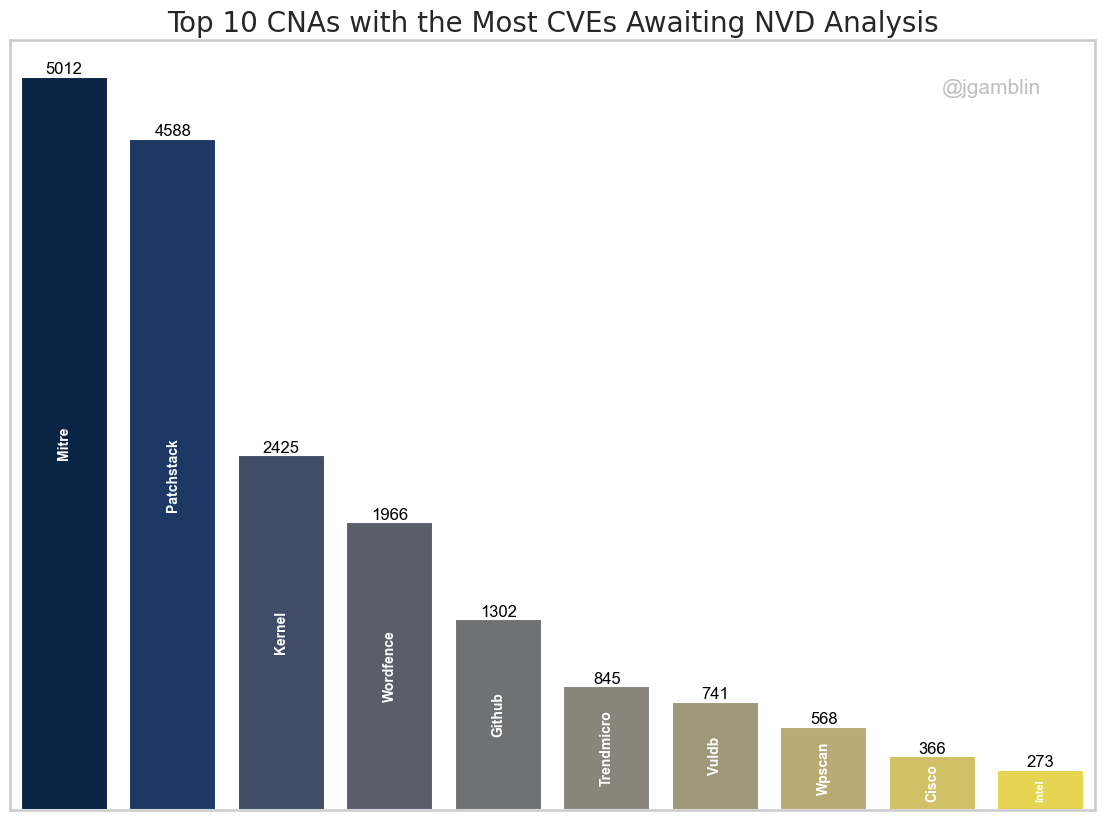

In [14]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract domain name without TLD from email address and capitalize it
def extract_and_capitalize_domain(email):
    match = re.search(r'@([\w.-]+)', email)
    if match:
        domain = match.group(1)
        domain_without_tld = '.'.join(domain.split('.')[:-1])  # Remove the TLD
        return domain_without_tld.capitalize()
    return email.capitalize()

# Apply the function to the 'Assigner' column to create a 'CNA' column with capitalized domain names without TLD
nvd['CNA'] = nvd['Assigner'].apply(extract_and_capitalize_domain)

# Replace assigner with UUID starting with 4 to "Linux Kernel"
nvd.loc[nvd['Assigner'].str.startswith('4'), 'CNA'] = 'Linux Kernel'

# Filter the DataFrame to include only CVEs Awaiting Analysis
awaiting_analysis_cves = nvd[nvd['Status'] == 'Awaiting Analysis']

# Count the number of CVEs Awaiting Analysis assigned by each CNA
awaiting_analysis_cna_counts = awaiting_analysis_cves['CNA'].value_counts().reset_index()
awaiting_analysis_cna_counts.columns = ['CNA', 'Count']

# Filter to show only the top 10 CNAs
top_awaiting_analysis_cnas = awaiting_analysis_cna_counts.head(10)

# Set the style and context for the plot
sns.set(style="whitegrid", context="talk")

# Create a custom color palette using the cividis colormap
cividis = plt.get_cmap('cividis', 10)
custom_palette = [cividis(i / 10) for i in range(10)]

# Create a vertical bar chart for the top 10 CNAs with the most CVEs Awaiting Analysis
plt.figure(figsize=(14, 10))
bar_chart = sns.barplot(data=top_awaiting_analysis_cnas, x='CNA', y='Count', hue='CNA', dodge=False, palette=custom_palette, legend=False)

# Add data labels to the bars
for index, value in enumerate(top_awaiting_analysis_cnas['Count']):
    plt.text(index, value, str(value), color='black', ha='center', va='bottom', fontsize=12)
    cna_label = top_awaiting_analysis_cnas['CNA'][index]
    font_size = 8 if cna_label.lower() == 'intel' else 10
    plt.text(index, value / 2, cna_label, color='white', ha='center', va='center', fontsize=font_size, weight='bold', rotation=90)

# Set plot title and labels
plt.title('Top 10 CNAs with the Most CVEs Awaiting NVD Analysis', fontsize=20, fontname='DejaVu Sans')
plt.xlabel('')
plt.ylabel('')

# Customize the ticks
plt.xticks([])
plt.yticks([])

# Remove all grid lines
plt.grid(False)

# Add a watermark in the upper right corner
plt.text(0.95, 0.95, '@jgamblin', fontsize=15, color='gray', ha='right', va='top', alpha=0.5, transform=plt.gca().transAxes)

# Save the plot as a PNG file with high resolution
plt.savefig('top_10_awaiting_analysis_cnas_bar.png', format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [ ]:
# Calculate the total number of CVEs
total_cves = len(nvd)

# Calculate the number of CVEs in "Awaiting Analysis"
awaiting_analysis_cves_count = len(awaiting_analysis_cves)

# Calculate the percentage of CVEs in "Awaiting Analysis"
awaiting_analysis_percentage = (awaiting_analysis_cves_count / total_cves) * 100

# Print the results with commas for numbers larger than 999
print(f"Number of CVEs in 'Awaiting Analysis': {awaiting_analysis_cves_count:,}")
print(f"Percentage of total CVEs that are 'Awaiting Analysis': {awaiting_analysis_percentage:.2f}%")

Number of CVEs in 'Awaiting Analysis': 23,828
Percentage of total CVEs that are 'Awaiting Analysis': 51.67%


In [ ]:
import re

# Function to extract domain name without TLD from email address and capitalize it
def extract_and_capitalize_domain(email):
    match = re.search(r'@([\w.-]+)', email)
    if match:
        domain = match.group(1)
        domain_without_tld = '.'.join(domain.split('.')[:-1])  # Remove the TLD
        return domain_without_tld.capitalize()
    return email.capitalize()

# Apply the function to the 'Assigner' column to create a 'CNA' column with capitalized domain names without TLD
nvd['CNA'] = nvd['Assigner'].apply(extract_and_capitalize_domain)

# Replace assigner with UUID starting with 4 to "Linux Kernel"
nvd.loc[nvd['Assigner'].str.startswith('4'), 'CNA'] = 'Linux Kernel'

# Filter the DataFrame to include only CVEs Awaiting Analysis
awaiting_analysis_cves = nvd[nvd['Status'] == 'Awaiting Analysis']

# Count the number of CVEs Awaiting Analysis assigned by each CNA
awaiting_analysis_cna_counts = awaiting_analysis_cves['CNA'].value_counts().reset_index()
awaiting_analysis_cna_counts.columns = ['CNA', 'Count']

# Filter to show only the top 10 CNAs
top_awaiting_analysis_cnas = awaiting_analysis_cna_counts.head(10)

# Calculate the total number of CVEs
total_cves = len(nvd)

# Calculate the number of CVEs in "Awaiting Analysis"
awaiting_analysis_cves_count = len(awaiting_analysis_cves)

# Calculate the percentage of CVEs in "Awaiting Analysis"
awaiting_analysis_percentage = (awaiting_analysis_cves_count / total_cves) * 100

# Calculate the number of CVEs for the top 10 CNAs in "Awaiting Analysis"
top_10_cnas_awaiting_analysis_count = top_awaiting_analysis_cnas['Count'].sum()

# Calculate the percentage of the top 10 CNAs' CVEs in "Awaiting Analysis" out of the total "Awaiting Analysis" CVEs
top_10_cnas_awaiting_analysis_percentage = (top_10_cnas_awaiting_analysis_count / awaiting_analysis_cves_count) * 100

# Print the results with commas for numbers larger than 999
print(f"Number of CVEs in 'Awaiting Analysis': {awaiting_analysis_cves_count:,}")
print(f"Percentage of total CVEs that are 'Awaiting Analysis': {awaiting_analysis_percentage:.2f}%")
print(f"Number of CVEs in 'Awaiting Analysis' for top 10 CNAs: {top_10_cnas_awaiting_analysis_count:,}")
print(f"Percentage of 'Awaiting Analysis' CVEs for top 10 CNAs: {top_10_cnas_awaiting_analysis_percentage:.2f}%")

Number of CVEs in 'Awaiting Analysis': 23,828
Percentage of total CVEs that are 'Awaiting Analysis': 51.67%
Number of CVEs in 'Awaiting Analysis' for top 10 CNAs: 18,086
Percentage of 'Awaiting Analysis' CVEs for top 10 CNAs: 75.90%
